In [3]:
from IPython.display import Image

# Preeliminares
## Comentar el código de simulación

estas clases están definidas en src/lib/simulador.py y src/lib/agente.py, acá mostramos algunas secciones interesantes

```python
class Simulador:
    def iterar_simulacion(self, collector = default_collector) -> Iterator[Dict[Country_Name, HS4_Product_Id]]:
        """Devuelve un iterador para poder simularlo por pasos.
        Toma una función (output:dict, pais, productos alcanzados en esta iteración)
        que permite cambiar que devuelve el simulador
        """
                
        while not self.es_fin_de_simulacion():
            output = {}
            # fase de decisiones
            for pais in self.paises():
                nuevos_productos = pais.elegir_productos()
                for pid in nuevos_productos:
                    pais.investigar_producto(pid)
            # fase de acciones
            for pais in self.paises():
                terminados = pais.avanzar_tiempo()
                collector(output, pais, terminados)
                pais.actualizar_exportaciones(terminados)

            self._actualizar_estado(output)
            self._notificar_paises()
            yield output


class SimuladorProductSpace(Simulador):
    """Simulador base, con paises Naive que opera sobre el grafo de
    proximidades, -mal llamado- product space (podría haber un espacio de productos distinto...)
    """

    def __init__(self,
                 criterio_parada: Callable[..., bool],
                 constructor_pais: Callable[..., IPais],
                 M: DataFrame, omega=0.4):
        ....

    def _estado_inicial_de_parada(self):
        self.current_step = 0

    def _actualizar_estado(self, _):
        "este simulador no actualiza nada más que el contador de iteraciones"
        self.current_step += 1

    def es_fin_de_simulacion(self):
        return self.criterio_parada(self.current_step)

```     

Algo parecido hacemos con los agentes -Paises- pero lo mostramos sobre la marcha

## datos

en ```src/lib/data.py```

```python
def get_oec_data_of_years(years, file_name = None):
    data = request_data_from(
        encode_url("https://oec.world/api/olap-proxy/data.jsonrecords",
                   {
                       "Year": ",".join(map(str, years)),
                       "cube": "trade_i_baci_a_92",
                       "drilldowns": "Exporter Country,Year,HS4",
                       "measures": "Trade Value",
                       "token": OEC_TOKEN
                   }))
    if file_name is not None:
        save_data_2_pickle(data, years, file_name)
    return data


def filter_biggests(df):
    df = df.copy()
    # Productos con más de $1.5 mil millones in global exports entre 2018-2020
    df_products = df.groupby('HS4 ID')['Trade Value'].sum().reset_index()
    df_products = df_products[df_products['Trade Value'] > 3*500000000]
    # Paises con más de $3 mil millones in global exports entre 2018-2020
    df_countries = df.groupby('Country')['Trade Value'].sum().reset_index()
    df_countries = df_countries[df_countries['Trade Value'] > 3*1000000000]

    df_filter = df[
        (df['Country'].isin(df_countries['Country'])) &
        (df['HS4 ID'].isin(df_products['HS4 ID']))
    ]
    return df_filter


def build_country_product_values_table(df):
    return pd.pivot_table(df, index=['Country'],
                          columns=['HS4 ID'],
                          values='Trade Value')\
             .reset_index()\
             .set_index('Country')\
             .dropna(axis=1, how="all")\
             .fillna(0)\
             .astype(float)
```

los datos por default se obtienen de:

```python
def get_default_oec_rca_raw_data() -> tuple[DataFrame, DataFrame]:
    """ Obtener de la API los años 2018, 2019, 2020, filtrar los
    volumenes más grandes pivotear...
    Devuelve (RCA, Datos Crudos)
    Todo esto debería ir en el informe medianamente justificado """
    try:
        df_raw = load_data_from_pickle()
    except Exception as e:
        print("Sucedió algo al intentar obtener los datos crudos cacheados:"
              + f"\n{e}"
              + "\n¡Descargando y guardando datos en caché!"
              + "\n... plz be patient ...")
        df_raw = get_oec_data_of_years(DEFAULT_YEARS, DEFAULT_OCE_FILE_NAME_PREFIX)
    df_filtered = filter_biggests(df_raw)
    return build_country_product_values_table(df_filtered), df_raw

```

# Ajuste de Parámetros
## Variación de Omega
```/src/diferencia-estatico-dinamico.ipynb```

De forma similar al trabajo anterior:

https://cnet.fi.uba.ar/netscix23/abstracts/Dynamics%20matter:%20A%20simulation%20framework%20to%20study%20diffusion%20processes%20on%20a%20Dynamic%20Product%20Space.pdf

Vamos a comparar la diferencia de productos descubiertos si el sistema es o no dinámico, variando el $\Omega$. 
Mostraremos evolución, tomando dos paises distintos, Argentina y Alemania, .

Como en el paper citado, la convergencia está en el orden de las unidades (3-5 iteraciones aprox), pero nuestros agentes pueden tardar hasta un máximo de 10 iteraciones en alcanzar un producto muy complejo, en este trabajo se iterara diez veces esa cantidad.

### - reproducción del paper anterior

en ```src/lib/simulador.py```

```python
class SimuladorEstatico(SimuladorProductSpace):
    def _notificar_paises(self):
        pass  # no hace falta hacer nada, porque no hay modificación


class SimuladorDinamico(SimuladorProductSpace):
    def _actualizar_estado(self, _):
        self.proximidad = ecplx.proximity(self.M)
        super()._actualizar_estado(_)

    def _notificar_paises(self):
        for p in self.paises():
            p.conocer_estado_del_mundo(proximidad=self.proximidad)
```

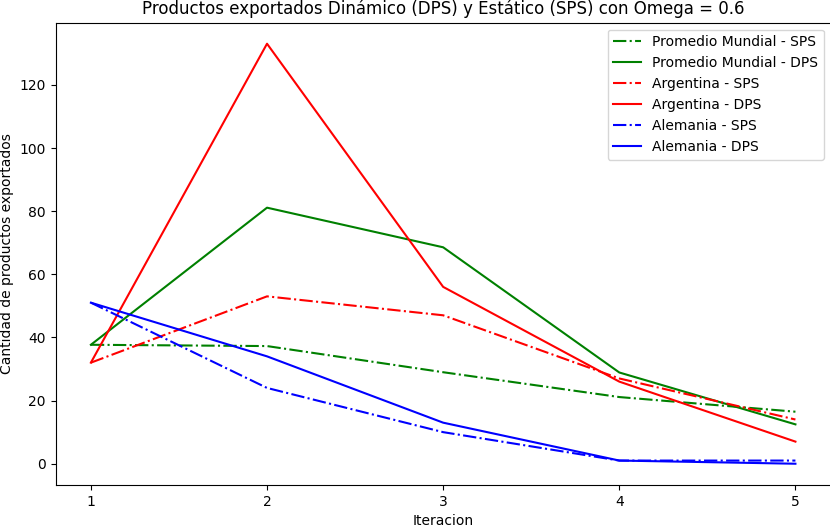

In [3]:
Image(filename='./img/dps-vs-sps-evolucion-productos-paper-omega-0.6.png')

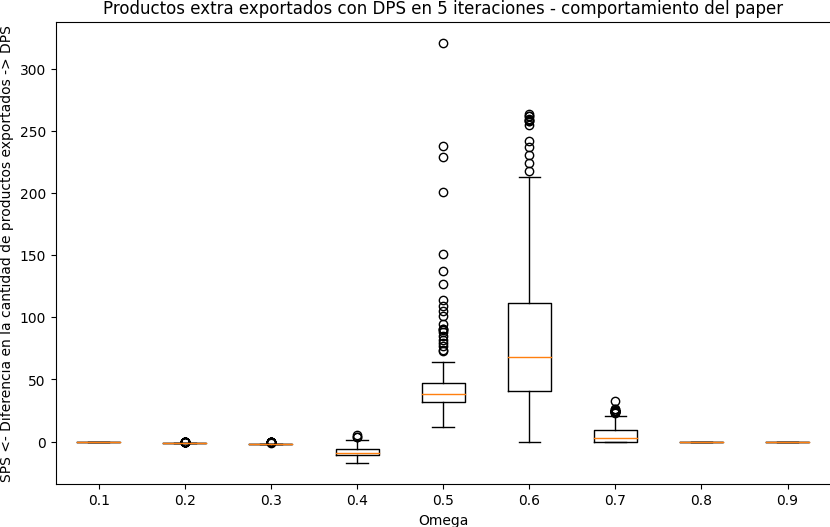

In [5]:
Image(filename="./img/dps-vs-sps-boxplot_comportamiento-del-paper-it_5.png")

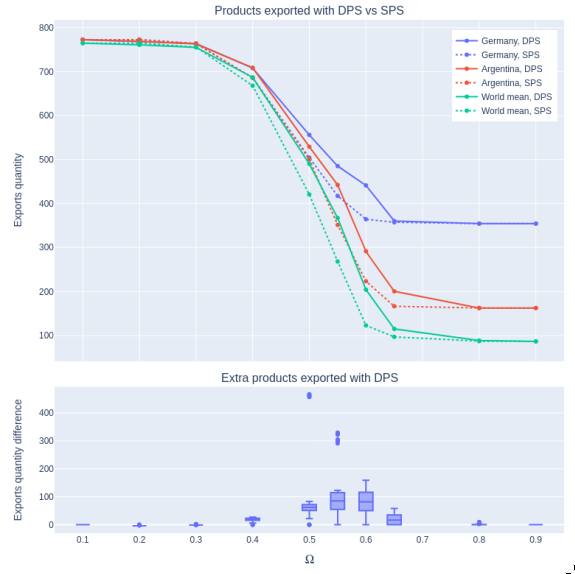

In [6]:
Image(filename="./img/paper-original.png")

### - resultados en un sistema de temporalidad variable

```python
class PaisConCotaProximidadMixin:
    ...

    def elegir_productos(self) -> List[HS4_Product_Id]:
        return self.frontera_de_productos()
    ...

class PaisNaive(PaisBaseMixin, PaisConCotaProximidadMixin, IPais):
   ...
    def tiempo_para_ser_competitivo(self, pid: HS4_Product_Id) -> Tiempo:
        return 1
    ...

class PaisComplejo(PaisNaive, IPais):
    ...

    def tiempo_para_ser_competitivo(self, pid: HS4_Product_Id) -> Tiempo:
        """ basicamente tomo las complejidades de productos y mapeo linealmente entre 0 y 10.
            es decir el producto mas sencillo tarda 0 iteraciones, el mas complejo 10. """
        return np.ceil(self.tiempo_maximo * (self.PCI.loc[pid] + np.abs(self.min_pci)) / self.max_pci)
    ...
    def conocer_estado_del_mundo(self, **kwargs):
        self.mi_eci = kwargs["eci"]
        self.PCI = kwargs["PCI"]
        super().conocer_estado_del_mundo(**kwargs)
```

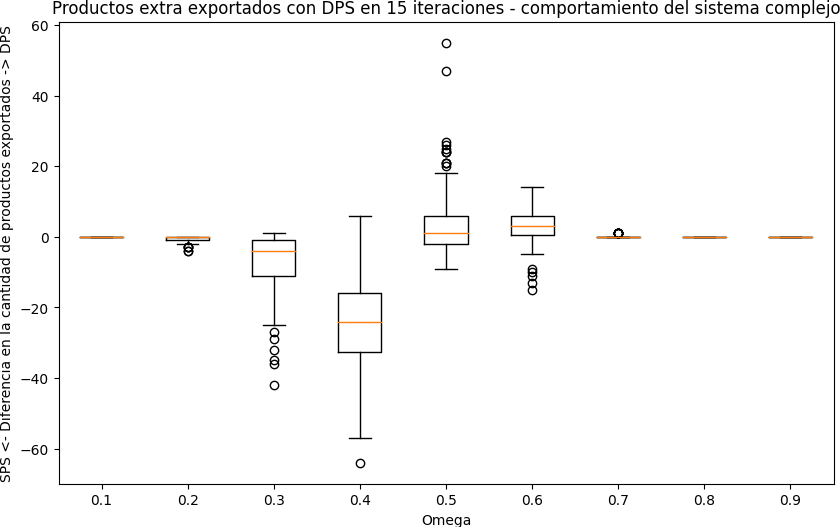

In [8]:
Image(filename="./img/dps-vs-sps-boxplot_comportamiento-del-sistema-complejo-it_15.png")

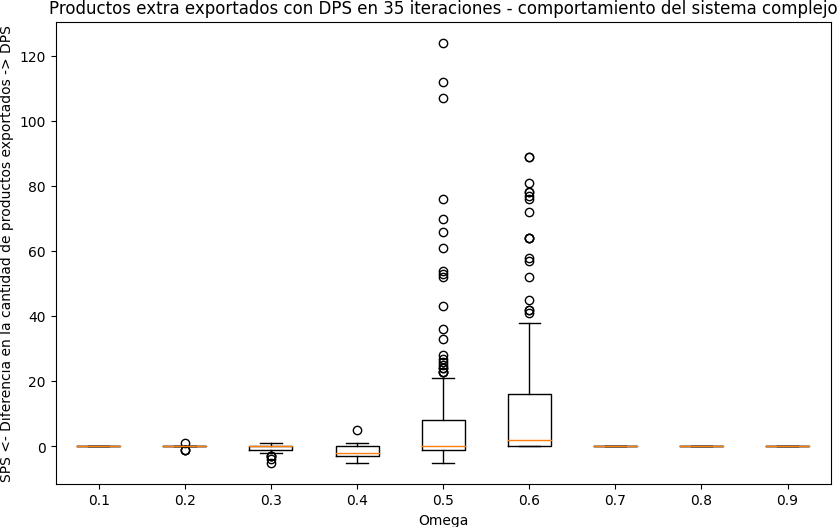

In [12]:
Image(filename="./img/dps-vs-sps-boxplot_comportamiento-del-sistema-complejo-it_35.png")

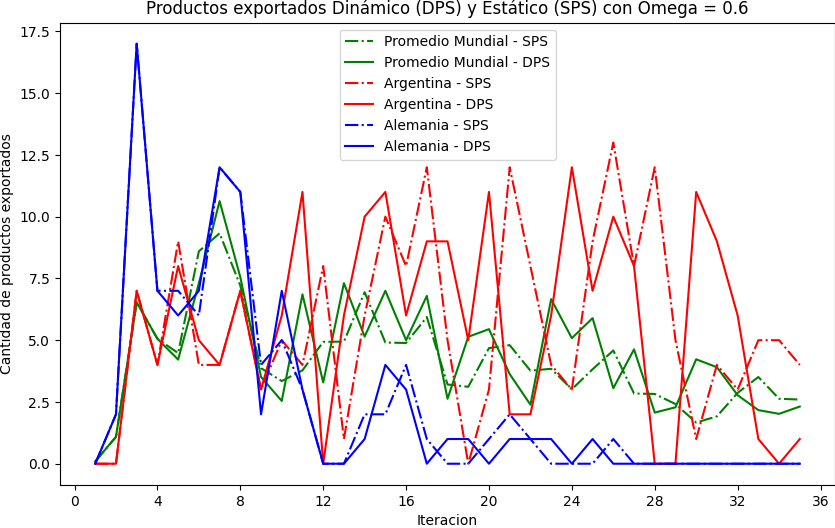

In [15]:
Image(filename="./img/dps-vs-sps-evolucion-productos--omega-0.6.png")

## Variación del Lag

Aqui experimentamos como cambia la simulación al variar el tiempo que tienen que esperar los paises para desarrollar sus productos.
Recordemos que el tiempo de espera por producto es $ \left \lceil \Delta * \text{PCI} + 1 \right \rceil$, donde $\text{PCI}$ es la complejidad del producto normalizada entre 0 y 1.

El valor de la variable $\Delta$ representa la cota máxima de espera para los productos. Es decir, el producto más complejo cuya complejidad tenga un $\text{PCI} = 1$ llevará $\Delta$ iteraciones para desarrollarse. Esto naturalmente implica que la simulación requiere más iteraciones para converger.

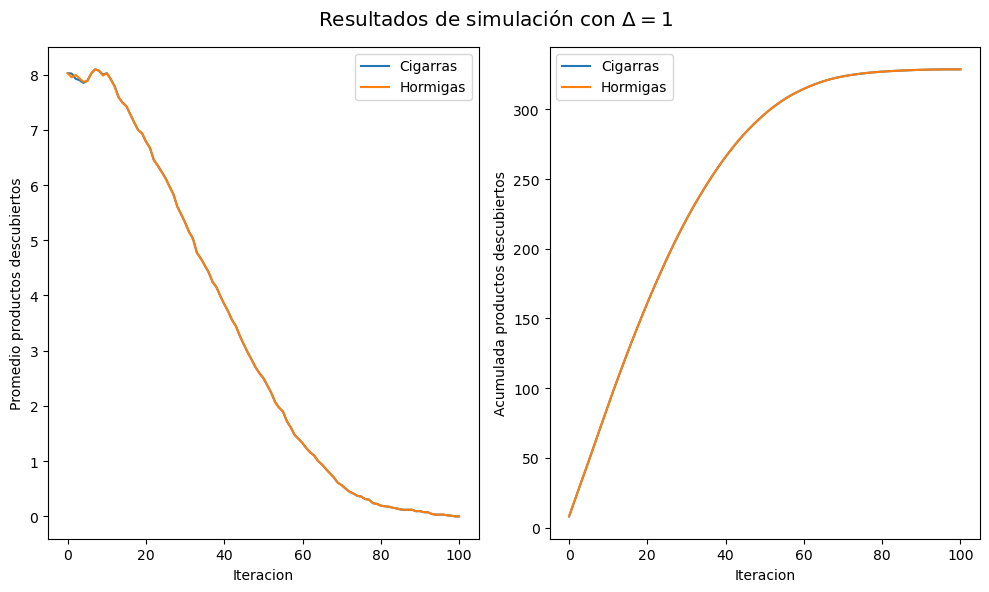

In [4]:
Image(filename="./img/lag_1.png")

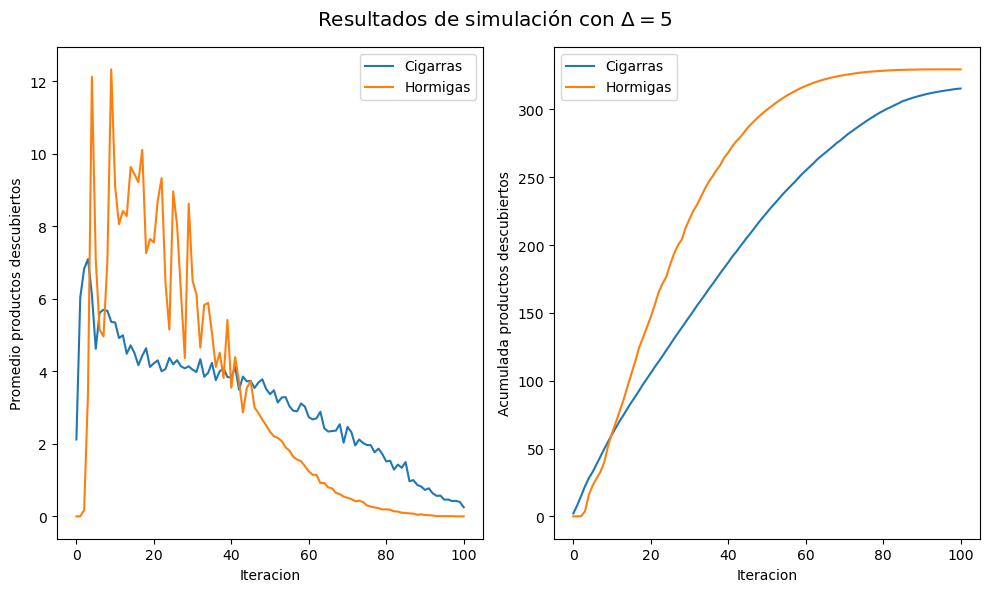

In [5]:
Image(filename="./img/lag_5.png")

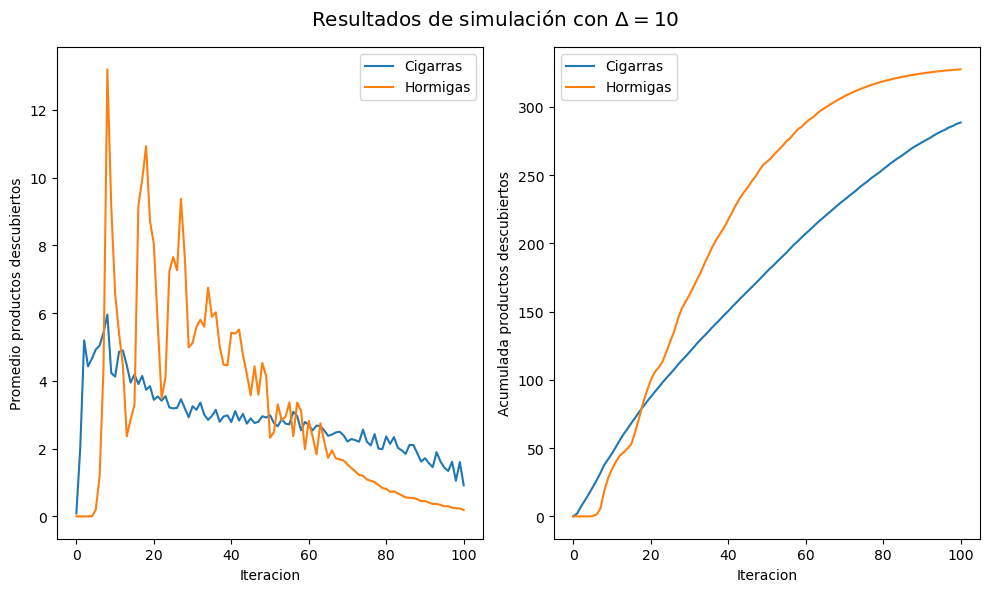

In [6]:
Image(filename="./img/lag_10.png")

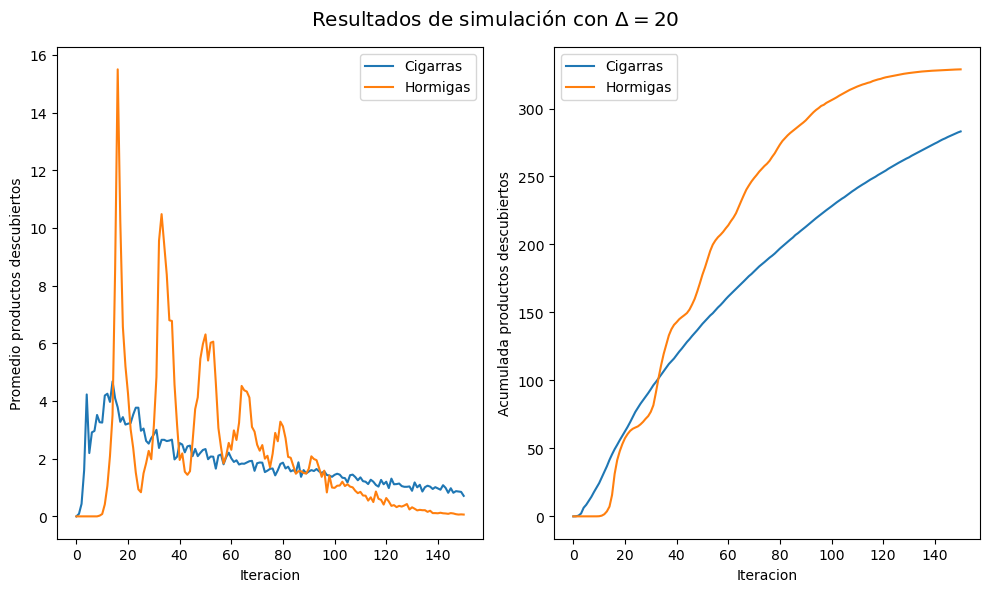

In [7]:
Image(filename="./img/lag_20.png")

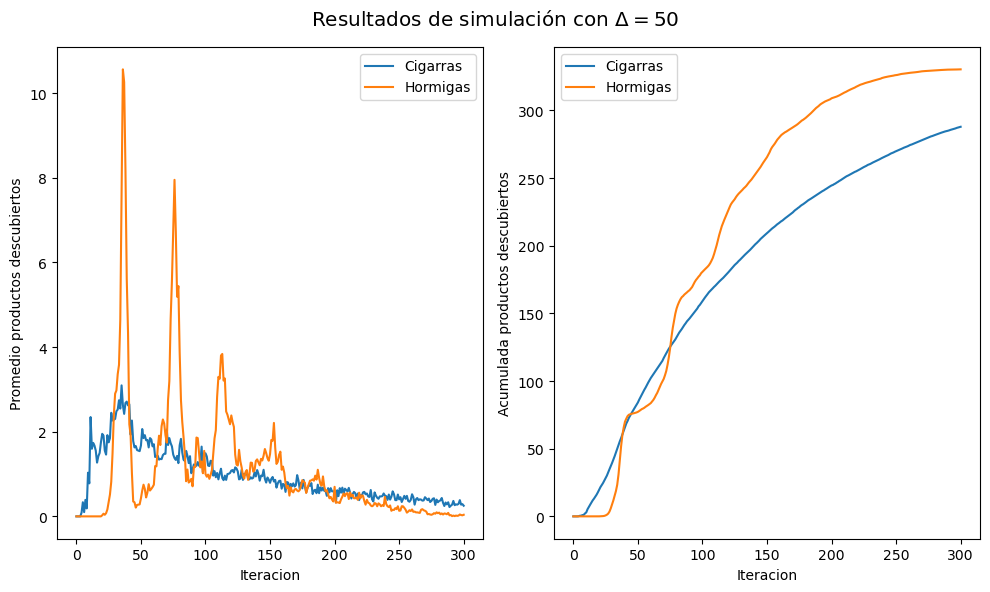

In [8]:
Image(filename="./img/lag_50.png")

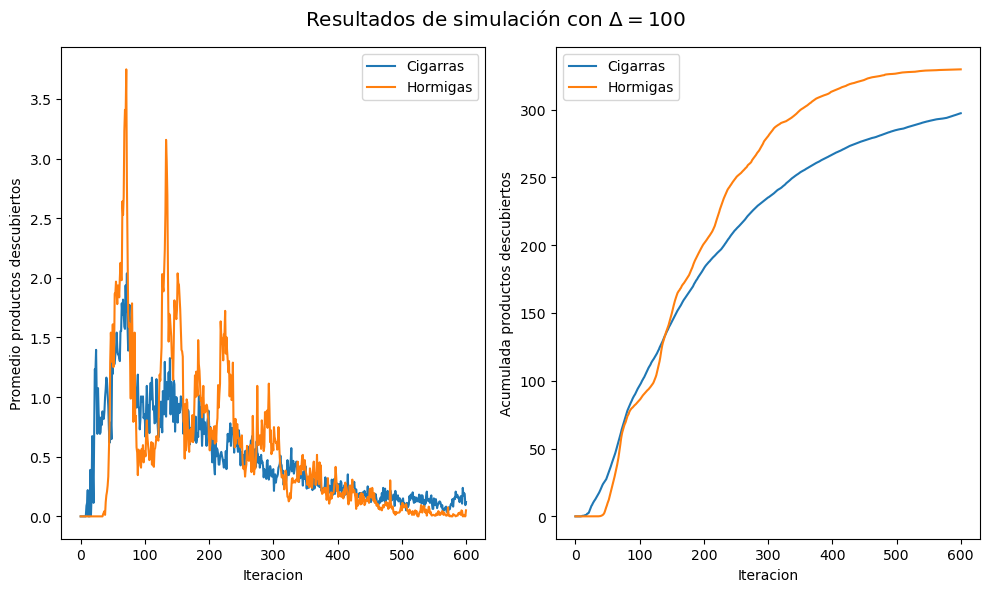

In [9]:
Image(filename="./img/lag_100.png")

## Exploración fija

Los resultados del experimento anterior pueden interpretarse como que investigar productos que incrementen el tamaño de la frontera visible de productos es particularmente importante. Incluso cuando los productos que más beneficio proveen en este aspecto requieren muchas iteraciones de desarrollo. Sin embargo, hay otro lugar de nuestro modelo donde estamos premiando este comportamiento, lo cual podría estar sesgado positivamente a los paises *hormiga*.

En nuestro modelo inicial, en cada iteración los paises *hormiga* y los paises *cigarra* eligen un 10% de su frontera de productos para desarrollar. Al expresar este comportamiento como un porcentaje estamos beneficiando a las estrategias que hagan crecer la frontera más rapidamente, esto podría estar ayudando a las *hormigas* especialmente.

Para este experimento estudiaremos cómo cambian los resultados si los países desarrollan una suma fija de productos, sin importar el tamaño de su frontera.

```python

class PaisHormigaFijo( PaisComplejo ):
    def __init__( self, phi, *args, **kwargs ):
        self.phi = phi
        super().__init__( *args, **kwargs )

    def elegir_productos(self) -> List[HS4_Product_Id]:
        "selecciona los primeros 10% de productos más complejos de su frontera"
        tiempos = self.tiempos_para_ser_competitivo()

        if len(tiempos) == 0:
            return []

        return tiempos.nlargest( min(len(tiempos), self.phi) ).index.to_list()


class PaisCigarraFijo( PaisComplejo ):
    def __init__( self, phi, *args, **kwargs ):
        self.phi = phi
        super().__init__( *args, **kwargs )

    def elegir_productos(self) -> List[HS4_Product_Id]:
        "selecciona los últimos 10% de productos más complejos de su frontera"
        tiempos = self.tiempos_para_ser_competitivo()
        
        if len(tiempos) == 0:
            return []

        return tiempos.nsmallest( min(len(tiempos), self.phi) ).index.to_list()
```

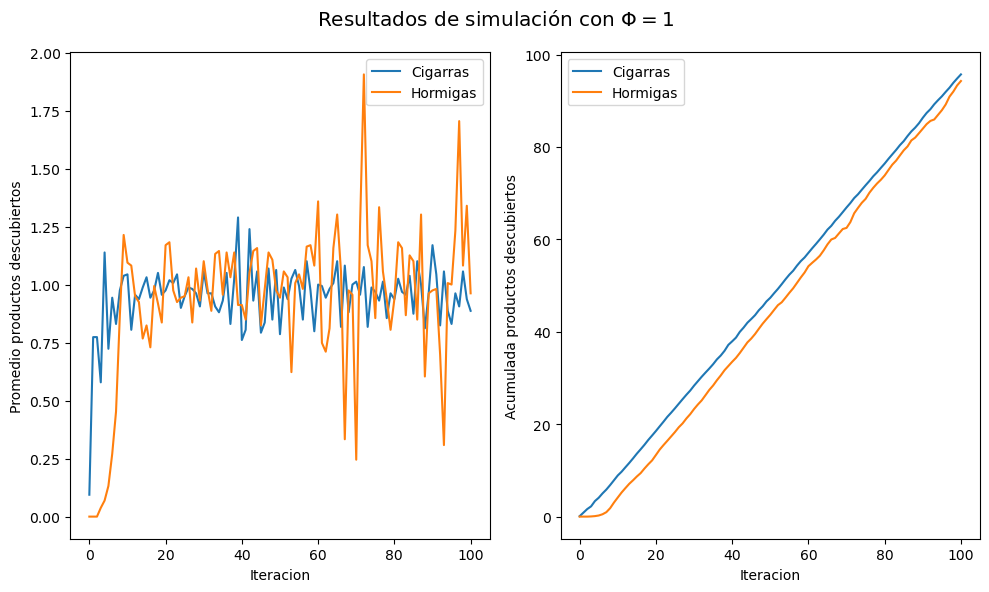

In [10]:
Image(filename="./img/phi_1.png")

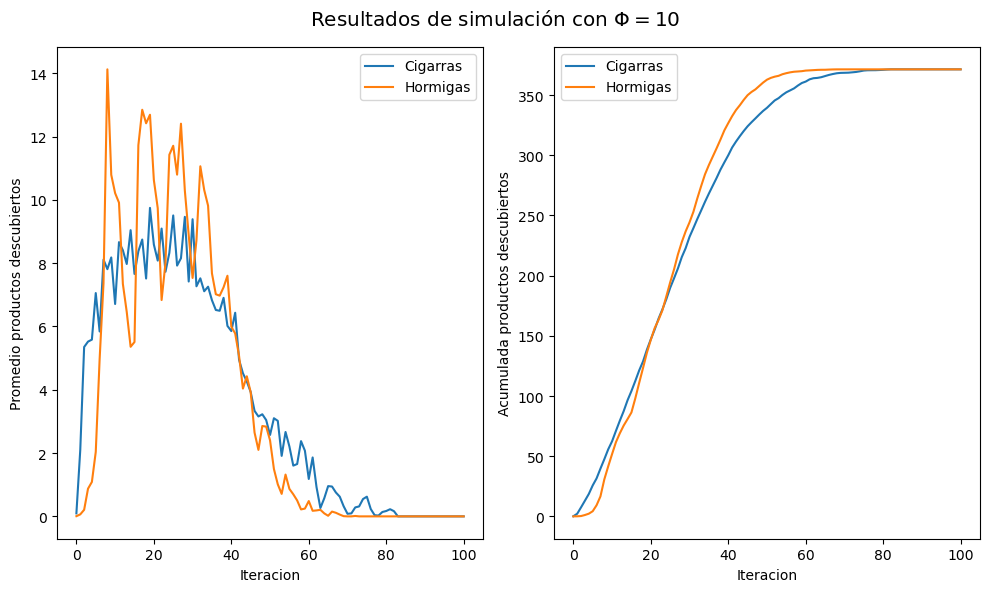

In [12]:
Image(filename="./img/phi_10.png")

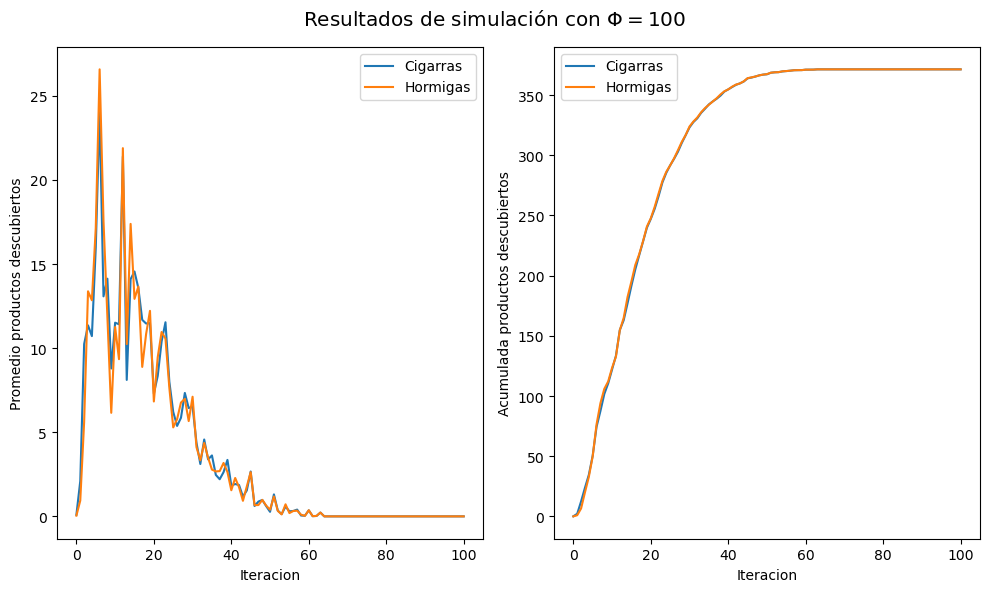

In [13]:
Image(filename="./img/phi_100.png")

Este experimento muestra que la complejidad de los paises esta directamente relacionada con la cantidad de paises accesibles que se encuentran en la frontera. Es por este motivo que la estrategia *hormiga* es superior.

# Un mundo dividido: Impacto de estrategias para paises periféricos y centrales en la complejidad de los paises
## - el ECI evoluciona: (mostrar grafiquito)
## - queremos ver el impacto agregado

en: ```src/diferencia-complejidad-por-estrategia.ipynb```

```python
def pais_factory_segun_complejidad(clase_periferico, clase_central):
    return lambda **constructor_args: \
        clase_central(**constructor_args) \
        if constructor_args["eci"] > 0 
        else clase_periferico(**constructor_args)

...

omega = 0.55
...


sim_perifericosHormigas_centralesHormigas = \
    SimuladorComplejo(lambda step: step >= iteraciones, 
                      pais_factory_segun_complejidad(
                          clase_periferico=PaisHormiga, clase_central=PaisHormiga), 
                      M.copy(deep=True), omega)
sim_perifericosHormigas_centralesCigarras = \
    SimuladorComplejo(lambda step: step >= iteraciones, 
                      pais_factory_segun_complejidad(
                          clase_periferico=PaisHormiga, clase_central=PaisCigarra), 
                      M.copy(deep=True), omega)
sim_perifericosCigarras_centralesHormigas = \
    SimuladorComplejo(lambda step: step >= iteraciones, 
                      pais_factory_segun_complejidad(
                          clase_periferico=PaisCigarra, clase_central=PaisHormiga), 
                      M.copy(deep=True), omega)
sim_perifericosCigarras_centralesCigarras = \
    SimuladorComplejo(lambda step: step >= iteraciones, 
                      pais_factory_segun_complejidad(
                          clase_periferico=PaisCigarra, clase_central=PaisCigarra), 
                      M.copy(deep=True), omega)
```

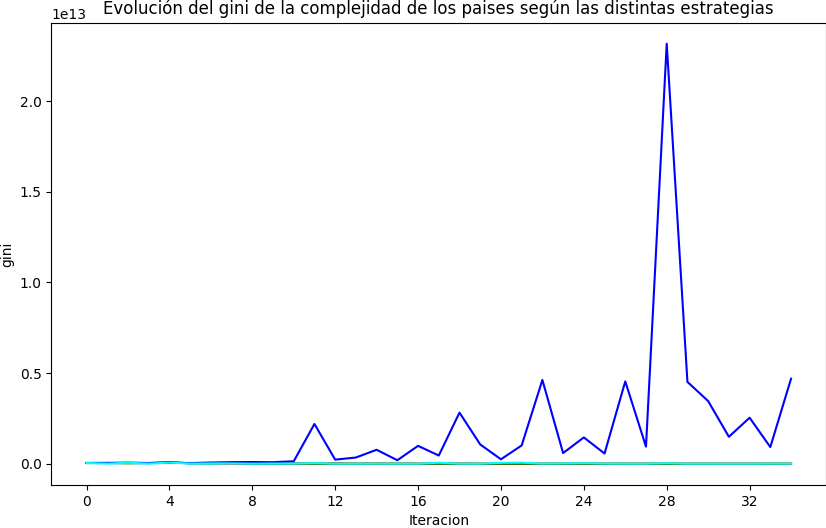

In [17]:
Image(filename='./img/estrategias-todas.png')

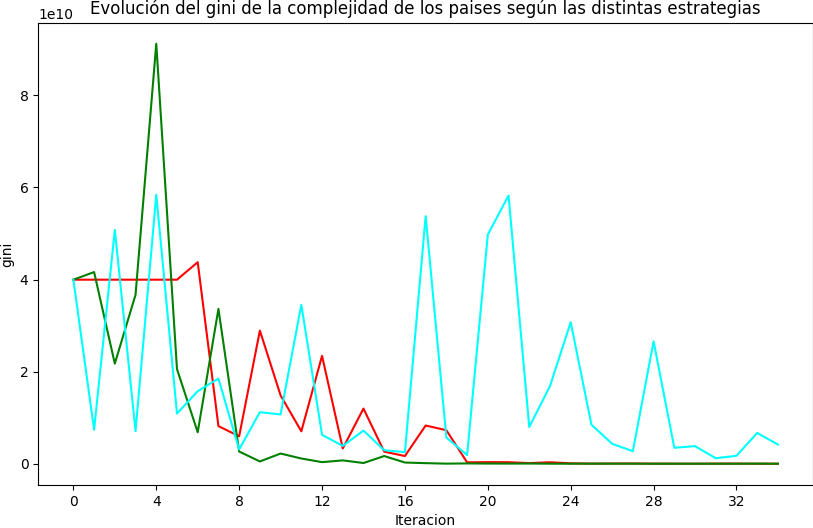

In [19]:
Image(filename='./img/estrategias-gini-3-estrategias.png')

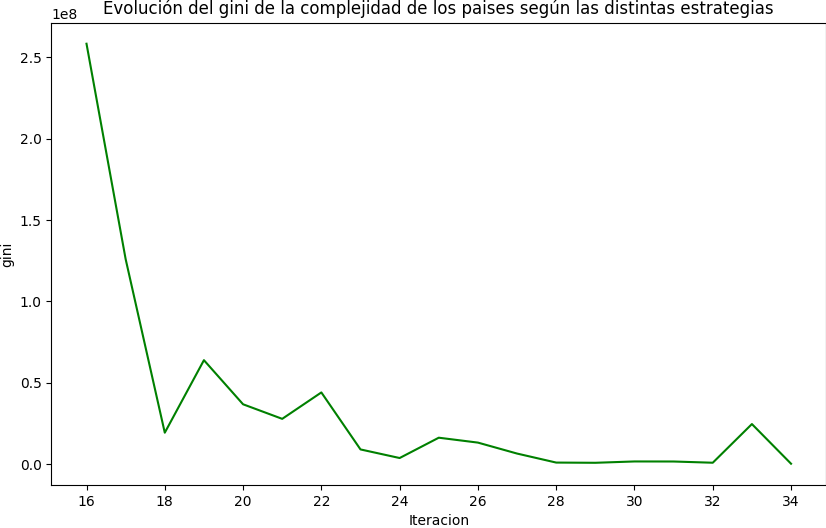

In [20]:
Image(filename='./img/estrategia-cola-de-mas-estable.png')

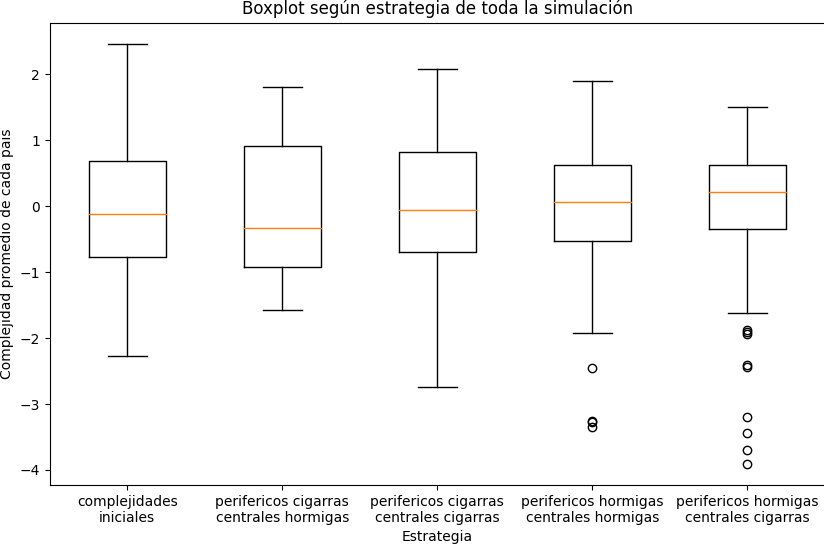

In [21]:
Image(filename='./img/extrategias-boxplot-todas-las-iteraciones.png')

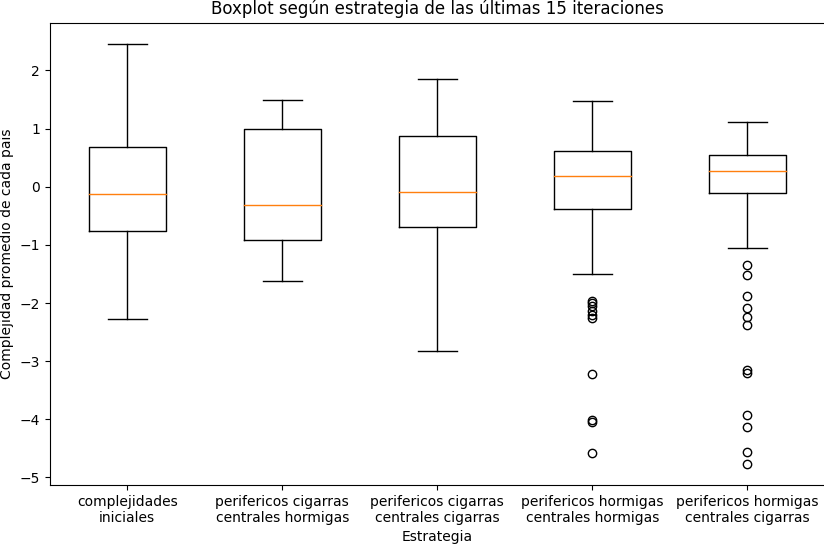

In [22]:
Image(filename='./img/estrategias-boxplot-ultimas-15.png')

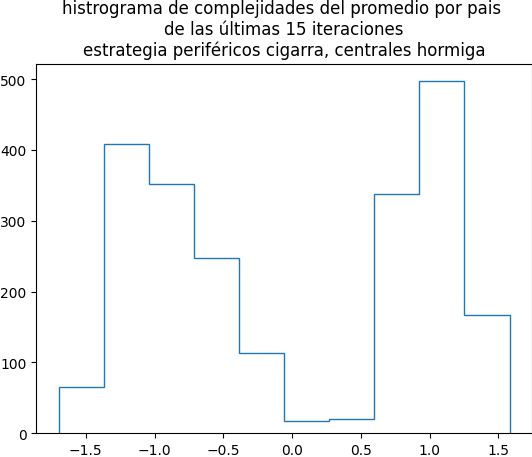

In [27]:
Image(filename='./img/estrategia-histograma-complejidades-camello.png')

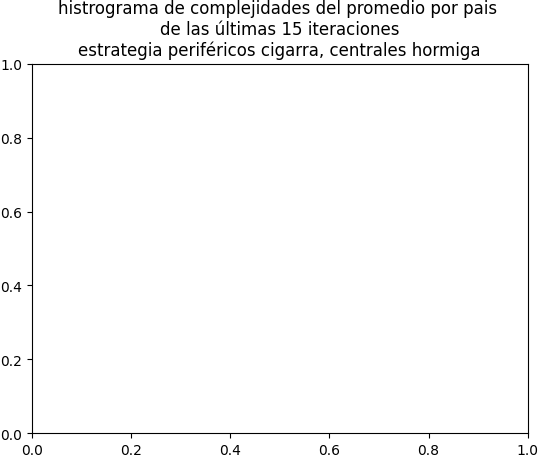

In [26]:
Image(filename='./img/estrategia-histograma-complejidades.png')

# Visualizacíon del Product Space

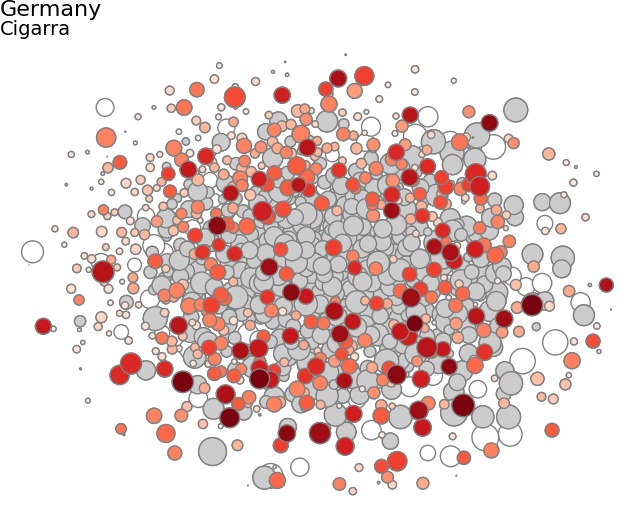

In [12]:
Image(filename='./img/grafo-cigarra_Germany.png')

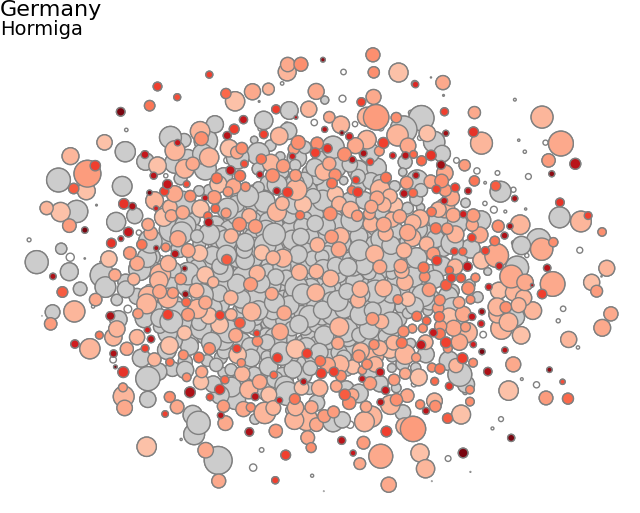

In [13]:
Image(filename='./img/grafo-hormiga_Germany.png')

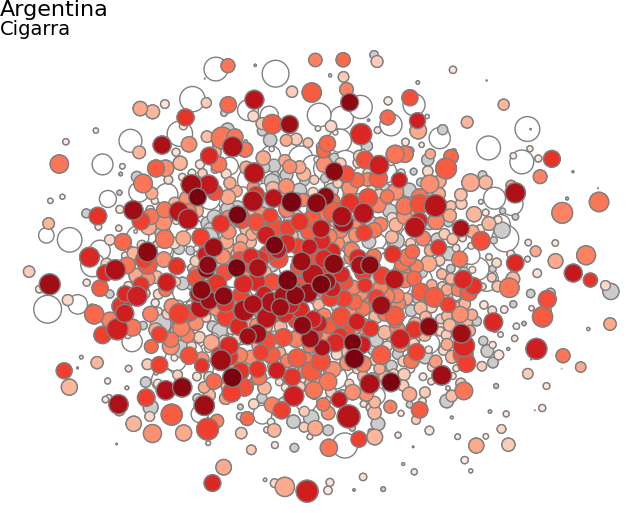

In [14]:
Image(filename='./img/grafo-cigarra_Argentina.png')

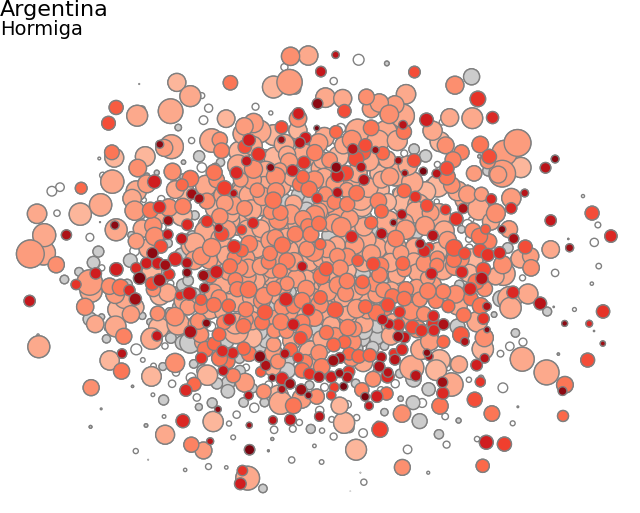

In [15]:
Image(filename='./img/grafo-hormiga_Argentina.png')

# Discusión y Próximos trabajos
- La matriz M, nunca "olvida" un producto
  - es irreal, es posible que un país pierda competitividad frente a otro que investigó el mismo producto
      - hay que modificar los valores de comercio y volver a calcular el RCA -> M
      - incorporar algún tipo de idea de dinero
- no modificamos la linealidad de la extrapolación temporal
    - queremos un modelo simple (alguna otra idea de por qué no lo hicimos?)
- no ponderamos el ECI de cada país para el tiempo de investigación/inversión.
    - idem
- ... otras cosas que hablamos y no recuerdo